<a href="https://colab.research.google.com/github/SaloWi/cas_mod4/blob/main/M6_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## M6 Project

#### Mayra and Salomé

**1. Introduction**

Medical insurance pricing is influenced by multiple factors, including demographic and lifestyle variables. In this project, we analyze a dataset containing information about individuals' insurance charges alongside features such as age, BMI, smoking status, children, and gender.

**2. Dataset Overview**

The dataset consists of the following key variables:

**Age:** The age of the individual.

**BMI (Body Mass Index):** A measure of body fat based on height and weight.

**Gender:** The biological sex of the individual (e.g., male, female).

**Children:** The amount of children an individual has.

**Smoker:** Whether the individual is a smoker (yes/no).

**Region:** The geographical region where the individual resides.

**Charges:** The total medical insurance cost for the individual.


**3. Objective**

The goal of this project is to build a predictive model using a neural network to estimate insurance charges based on the given features. By doing so, we aim to:


*   Identify the most significant factors affecting insurance costs.

*   Assess how well a neural network can predict charges compared to another model.
*   Understand the impact of lifestyle choices (e.g., smoking) on pricing.

In [2]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import mean_absolute_percentage_error

import torch.nn as nn
import torch.optim as optim
import plotly.express as px
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

import pickle


In [3]:
# Upload dataset
from google.colab import files
uploaded = files.upload()

Saving insurance.csv to insurance.csv


In [4]:
# Load dataset
data = pd.read_csv('insurance.csv')
# Display the first few rows
print(data.head())
# Check for missing values
print(data.isnull().sum())
# Basic overview
print(data.describe())
# Display data types
print(data.info())

   age     sex     bmi  children smoker     region      charges
0   19  female  27.900         0    yes  southwest  16884.92400
1   18    male  33.770         1     no  southeast   1725.55230
2   28    male  33.000         3     no  southeast   4449.46200
3   33    male  22.705         0     no  northwest  21984.47061
4   32    male  28.880         0     no  northwest   3866.85520
age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64
               age          bmi     children       charges
count  1338.000000  1338.000000  1338.000000   1338.000000
mean     39.207025    30.663397     1.094918  13270.422265
std      14.049960     6.098187     1.205493  12110.011237
min      18.000000    15.960000     0.000000   1121.873900
25%      27.000000    26.296250     0.000000   4740.287150
50%      39.000000    30.400000     1.000000   9382.033000
75%      51.000000    34.693750     2.000000  16639.912515
max      64.000000    53.130000  

### Descriptives

This section focuses on the descriptive analysis to understand the distribution of key variables in our insurance dataset. Specifically, we generate different visualizations to illustrate the distribution of 'sex', 'smoker', 'bmi' and 'region' in connection with the insurance charges.

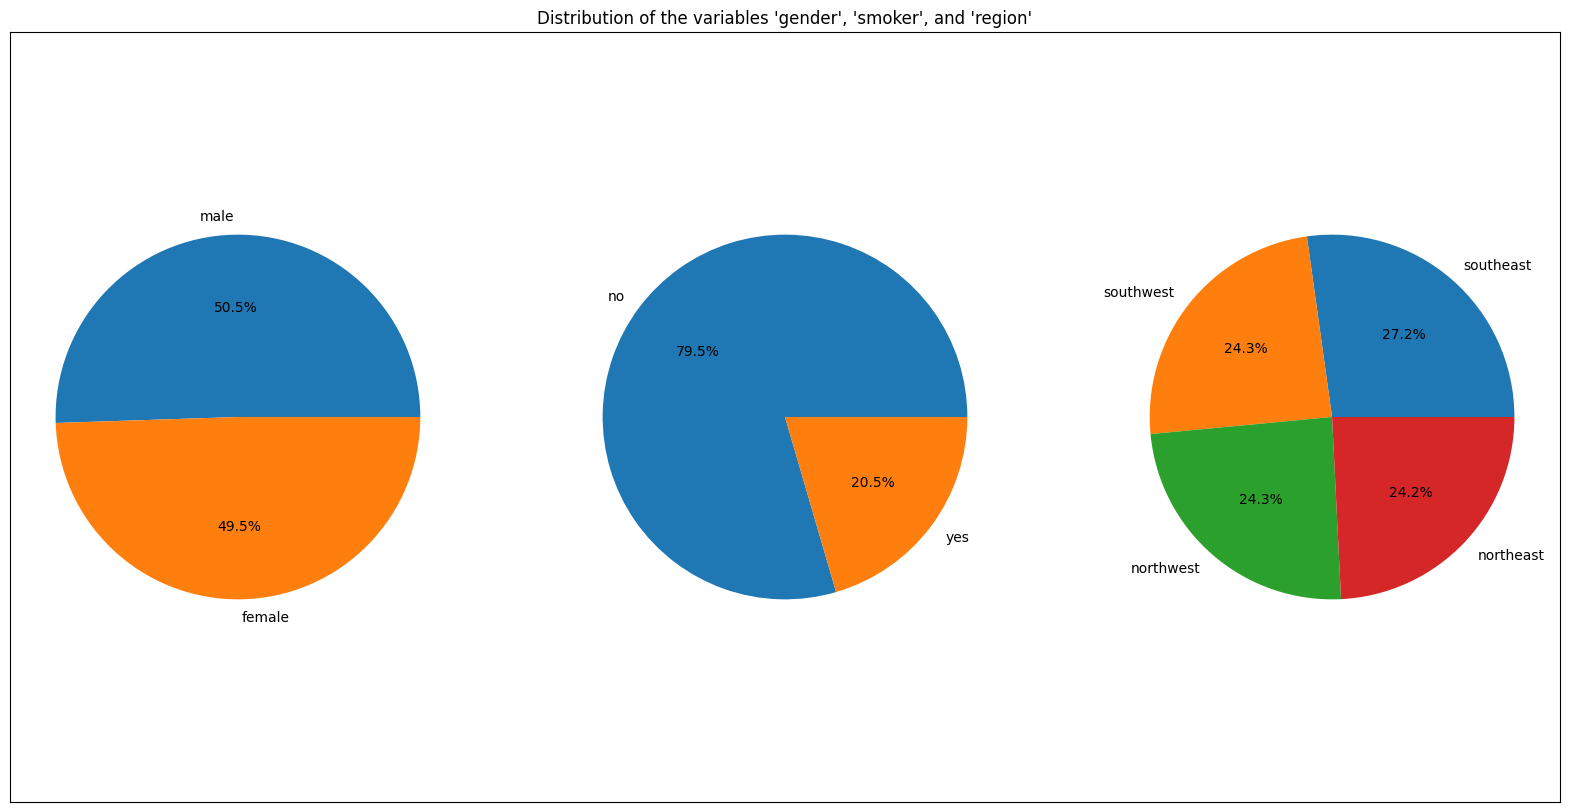

In [19]:
# Generate plot of the distribution of the variables 'sex', 'smoker', and 'region'
features = ['sex', 'smoker', 'region']

plt.subplots(figsize=(20, 10))
plt.title('Distribution of the variables \'gender\', \'smoker\', and \'region\'')
plt.xticks([], [])
plt.yticks([], [])
for i, col in enumerate(features):
    plt.subplot(1, 3, i + 1)

    x = data[col].value_counts()
    plt.pie(x.values,
            labels=x.index,
            autopct='%1.1f%%')

plt.show()

Looking at the distribution, we see an equal representation of men and women as well as individuals from the four regions in the data set. Furthermore, a majority of the individuals are non-smokers.

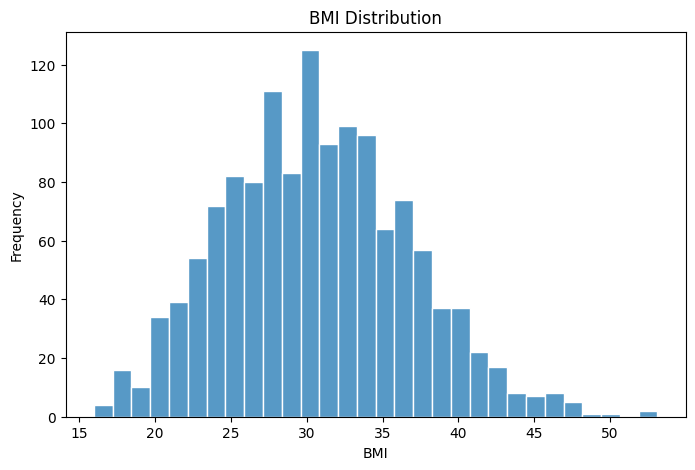

30.66339686098655


In [23]:
plt.figure(figsize=(8, 5))
sns.histplot(data['bmi'], bins=30, kde=False, edgecolor = "white")
plt.xlabel("BMI")
plt.ylabel("Frequency")
plt.title("BMI Distribution")
plt.show()

Here, we see the distribution of the bmi-values of the individuals in the dataset. The average bmi-value is 30.66 and in general, the data is approximately normally distributed.

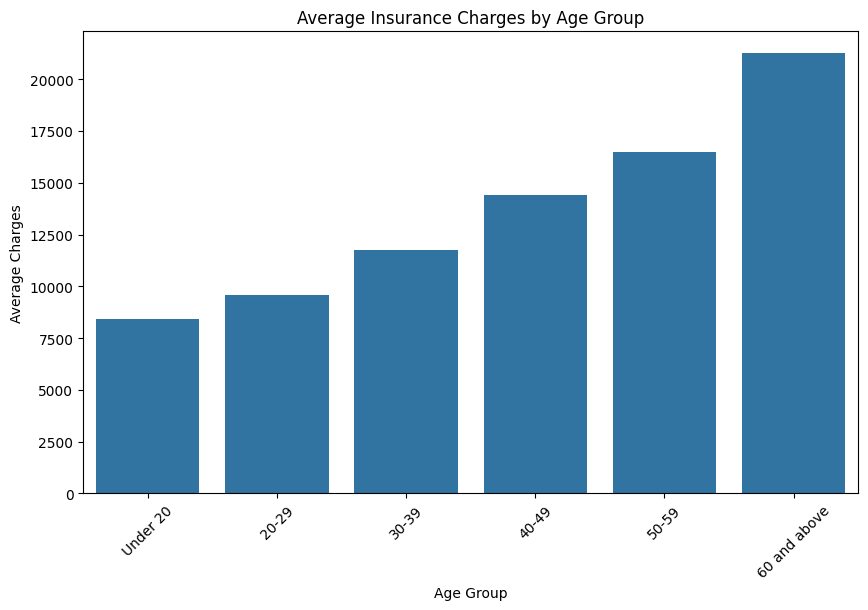

In [6]:
# Plot the average insurance charges per age group
def age_group(age):
    if age < 20:
        return 'Under 20'
    elif 20 <= age < 30:
        return '20-29'
    elif 30 <= age < 40:
        return '30-39'
    elif 40 <= age < 50:
        return '40-49'
    elif 50 <= age < 60:
        return '50-59'
    else:
        return '60 and above'
data['age_group'] = data['age'].apply(age_group)
average_cost_by_age_group = data.groupby('age_group')['charges'].mean()

age_order = ['Under 20', '20-29', '30-39', '40-49', '50-59', '60 and above']

plt.figure(figsize=(10, 6))
sns.barplot(x=average_cost_by_age_group.index, y=average_cost_by_age_group.values, order=age_order)
plt.title('Average Insurance Charges by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Average Charges')
plt.xticks(rotation=45)
plt.show()

This plot helps us understand how insurance costs tend to change as individuals get older. We can observe that the average charges per age group increase for older age groups. Hence, older age groups have higher average charges compared to younger age groups.

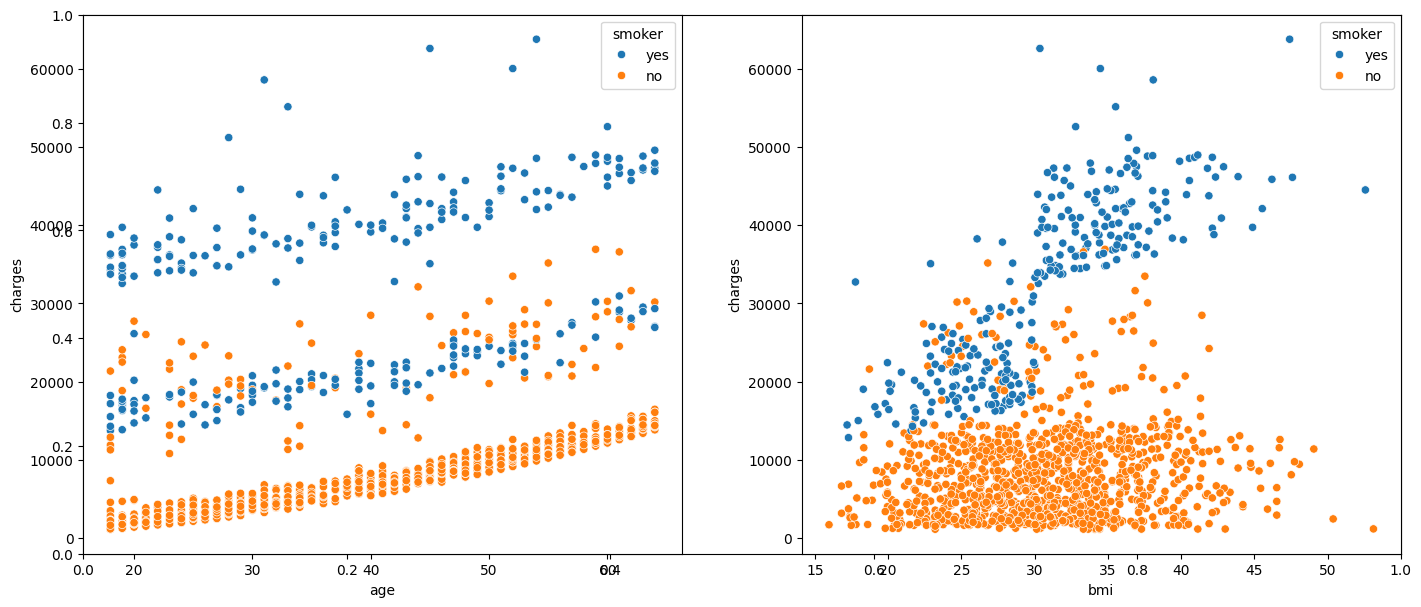

In [ ]:
# Plot the distribution of charges across age and bmi-measures for different smoker types

features = ['age', 'bmi']

plt.subplots(figsize=(17, 7))
for i, col in enumerate(features):
    plt.subplot(1, 2, i + 1)
    sns.scatterplot(data=data, x=col,
                   y='charges',
                   hue='smoker')
plt.show()

This comparison of the insurance charges of smokers and non-smokers according to their age and bmi-index provides interesting insights.

On the left side, we see that charges for smokers are in general higher than for non-smokers and that charges increase with older age. In addition, there seem to be two groups of charges for each condition.

In order to further investigate these types of groups, we look at the dsitribution of charges from smokers and non-smokers according to their bmi-index. On the right side, it is again visible that charges are in general higher for smokers than for non-smokers. In addition, we can see that smokers who are above a certain bmi-threshold of 30, the insurance charges double.

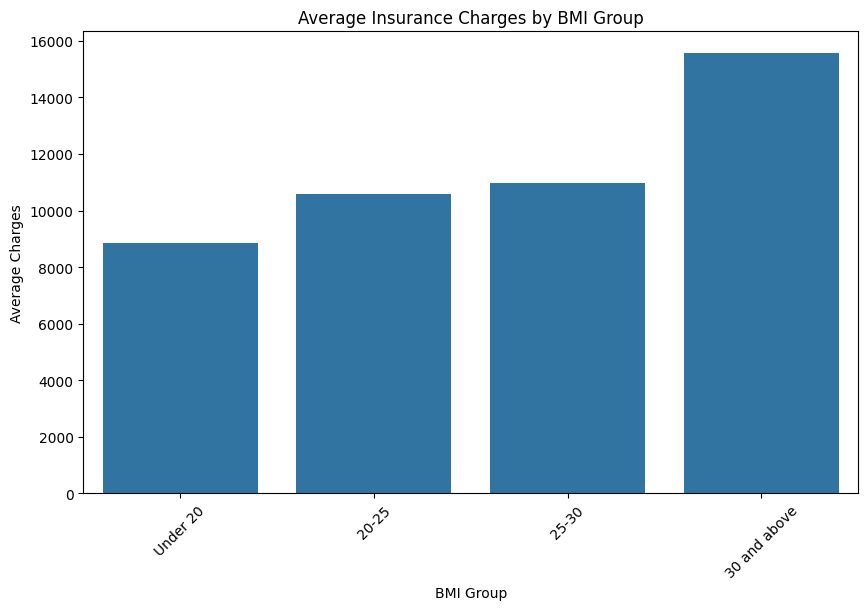

In [47]:
# Plot the average insurance charges per age group
def bmi_group(bmi):
    if bmi < 20:
        return 'Under 20'
    elif 20 <= bmi < 25:
        return '20-25'
    elif 25 <= bmi < 30:
        return '25-30'
    else:
        return '30 and above'
data['bmi_group'] = data['bmi'].apply(bmi_group)
average_cost_by_bmi_group = data.groupby('bmi_group')['charges'].mean()

bmi_order = ['Under 20', '20-25','25-30', '30 and above']

plt.figure(figsize=(10, 6))
sns.barplot(x=average_cost_by_bmi_group.index, y=average_cost_by_bmi_group.values, order=bmi_order)
plt.title('Average Insurance Charges by BMI Group')
plt.xlabel('BMI Group')
plt.ylabel('Average Charges')
plt.xticks(rotation=45)
plt.show()

This leads us to look at the distribution of insurance charges for bmi-groups too. This plot confirms what was noticed in the previous visualization. Insurance charges increase with increasing bmi-index, but for bmi-indexes of 30 and above, the increase of charges grows noticeably.

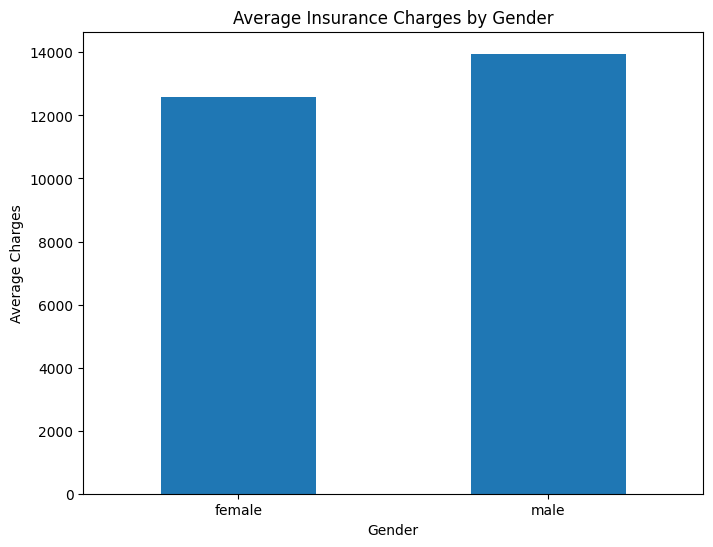

In [24]:
# Plot the average insurance charges for each gender
average_cost_by_sex = data.groupby('sex')['charges'].mean()

plt.figure(figsize=(8, 6))
average_cost_by_sex.plot(kind='bar')
plt.title('Average Insurance Charges by Gender')
plt.xlabel('Gender')
plt.ylabel('Average Charges')
plt.xticks(rotation=0)
plt.show()

To finalize the descriptive analysis, we look at the average insurance charges for the gender values. As can be observed, the average charges are slightly higher for men than for women.

### Prepare data for NN

In [88]:
# Encode categorical variables
categorical_columns = ['sex', 'smoker', 'region']
encoder = LabelEncoder()
for col in categorical_columns:
    data[col] = encoder.fit_transform(data[col])
print(data)
# Features and target variable
X = data.drop(columns=['charges', 'age_group', 'bmi_group'])  # Features
y = data['charges']                 # Target (insurance cost)
# Normalize numeric features
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)


      age  sex     bmi  children  smoker  region      charges     age_group  \
0      19    0  27.900         0       1       3  16884.92400      Under 20   
1      18    1  33.770         1       0       2   1725.55230      Under 20   
2      28    1  33.000         3       0       2   4449.46200         20-29   
3      33    1  22.705         0       0       1  21984.47061         30-39   
4      32    1  28.880         0       0       1   3866.85520         30-39   
...   ...  ...     ...       ...     ...     ...          ...           ...   
1333   50    1  30.970         3       0       1  10600.54830         50-59   
1334   18    0  31.920         0       0       0   2205.98080      Under 20   
1335   18    0  36.850         0       0       2   1629.83350      Under 20   
1336   21    0  25.800         0       0       3   2007.94500         20-29   
1337   61    0  29.070         0       1       1  29141.36030  60 and above   

         bmi_group  
0            25-30  
1     30 

In [ ]:
# Split the data in train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
# Build the model
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1)  # Single output for regression
])
# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])  # MSE and MAE for regression


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



In [ ]:
# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=32
)


Epoch 1/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 293003840.0000 - mae: 12846.3301 - val_loss: 323383968.0000 - val_mae: 12966.9980
Epoch 2/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 354992736.0000 - mae: 13924.7295 - val_loss: 323298656.0000 - val_mae: 12964.2578
Epoch 3/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 313414208.0000 - mae: 13157.1709 - val_loss: 323106048.0000 - val_mae: 12958.4287
Epoch 4/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 327916256.0000 - mae: 13333.1035 - val_loss: 322720160.0000 - val_mae: 12947.2266
Epoch 5/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 324131040.0000 - mae: 13239.9531 - val_loss: 322030400.0000 - val_mae: 12927.8652
Epoch 6/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 324516448.0000 - mae: 13407.9404 - val_loss: 320924992.0000 - val_mae: 12897.9209
Epoch 7/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 309263968.0000 - mae: 13055.7168 - val_loss: 319287840.0000 - val_mae: 12854.5605
Epoch 8/50
34/34 ━━

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 29691670.0000 - mae: 3887.5715 
Test Loss (MSE): 32659352.0
Test Mean Absolute Error (MAE): 4028.038818359375
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


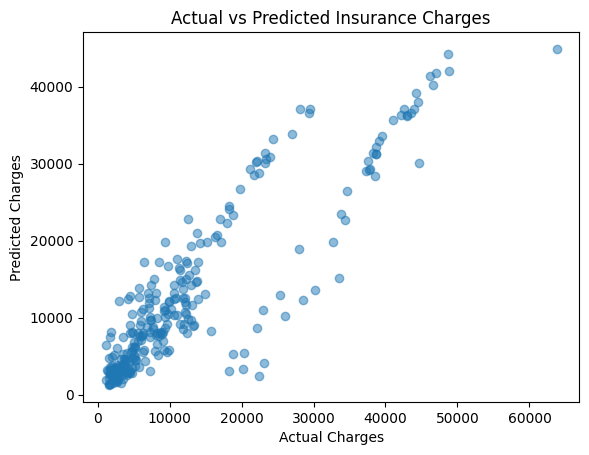

In [ ]:
# Evaluate on the test set
test_loss, test_mae = model.evaluate(X_test, y_test)
print(f"Test Loss (MSE): {test_loss}")
print(f"Test Mean Absolute Error (MAE): {test_mae}")

# Make predictions
y_pred = model.predict(X_test)
# Compare predictions vs actual values
import matplotlib.pyplot as plt
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel("Actual Charges")
plt.ylabel("Predicted Charges")
plt.title("Actual vs Predicted Insurance Charges")
plt.show()


In [ ]:
# Calculate the mean absolute percentage error
mape = mean_absolute_percentage_error(y_test, y_pred)
print(f'Mean abolute percentage error: {mape * 100:.2f}%')

Mean abolute percentage error: 42.00%


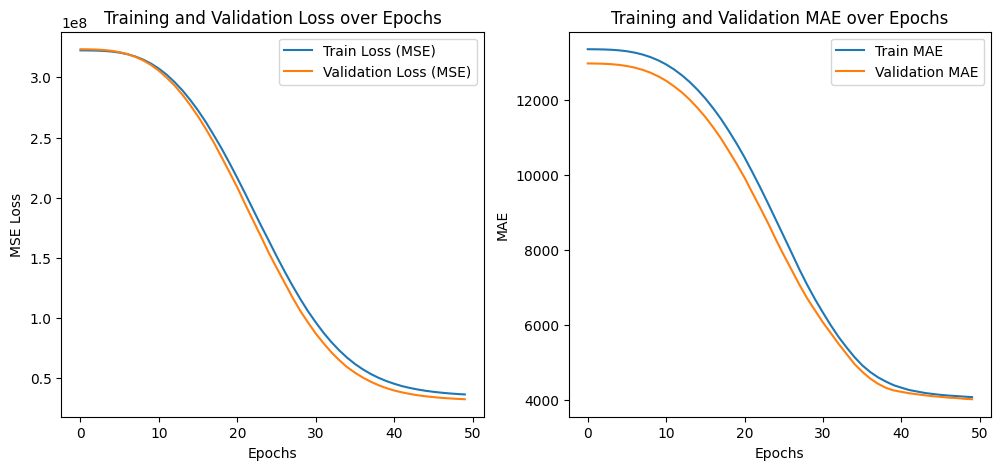

In [ ]:
# Plot training & validation loss values
plt.figure(figsize=(12, 5))

# Loss (MSE) Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss (MSE)')
plt.plot(history.history['val_loss'], label='Validation Loss (MSE)')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()

# Mean Absolute Error (MAE) Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.title('Training and Validation MAE over Epochs')
plt.legend()

plt.show()


## Different Model

SALOME: hier hönnte man zb noch bmi gruppieren mit tief mittel hoch, daraus dummies machen und dann analog zu den regions rein nehmen. so könnte man am ende auch diese boxplots nach bmi machen und schauen, ob diese die charges beeinflussen

In [25]:
df_backup = data

In [26]:
data['sex'] = LabelEncoder().fit_transform(data['sex'])
data['smoker'] = LabelEncoder().fit_transform(data['smoker'])

In [48]:
data_encoded = pd.get_dummies(data, columns=['region'])
data_encoded = pd.get_dummies(data_encoded, columns=['bmi_group'])

,age,sex,bmi,children,smoker,charges,age_group,region_0,region_1,region_2,region_3,bmi_group_20-25,bmi_group_25-30,bmi_group_30 and above,bmi_group_Under 20
0,19,0,27.900,0,1,16884.92400,Under 20,False,False,False,True,False,True,False,False
1,18,1,33.770,1,0,1725.55230,Under 20,False,False,True,False,False,False,True,False
2,28,1,33.000,3,0,4449.46200,20-29,False,False,True,False,False,False,True,False
3,33,1,22.705,0,0,21984.47061,30-39,False,True,False,False,True,False,False,False
4,32,1,28.880,0,0,3866.85520,30-39,False,True,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1333,50,1,30.970,3,0,10600.54830,50-59,False,True,False,False,False,False,True,False
1334,18,0,31.920,0,0,2205.98080,Under 20,True,False,False,False,False,False,True,False
1335,18,0,36.850,0,0,1629.83350,Under 20,False,False,True,False,False,False,True,False
1336,21,0,25.800,0,0,2007.94500,20-29,False,False,False,True,False,True,False,False


In [90]:
X = data_encoded.drop(['charges', 'age_group', 'bmi'], axis=1)
y = data_encoded['charges']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2024)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [91]:
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
y_test = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

In [115]:
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True)

val_dataset = TensorDataset(X_test, y_test)
val_loader = DataLoader(val_dataset, batch_size=10, shuffle=False)  # shuffle=False for validation

In [116]:
# Build and train the model
class RegressionModel(nn.Module):
    def __init__(self, input_dim):
        super(RegressionModel, self).__init__()
        self.layer1 = nn.Linear(input_dim, 64)
        self.layer2 = nn.Linear(64, 32)
        self.output = nn.Linear(32, 1)

    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = torch.relu(self.layer2(x))
        x = self.output(x)
        return x

model = RegressionModel(X_train.shape[1])
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [117]:
history = {'train_loss': [], 'val_loss': [], 'train_mae': [], 'val_mae': []} #

epochs = 240
for epoch in range(epochs):
    model.train() #
    train_loss = 0.0 #
    train_mae = 0.0  #

    for inputs, targets in train_loader:
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, targets)

        loss.backward()
        optimizer.step()

        train_loss += loss.item() * inputs.size(0)  #
        mae = torch.mean(torch.abs(outputs - targets)) #
        train_mae += mae.item() * inputs.size(0) #
          #
    train_loss /= len(train_loader.dataset) #
    train_mae /= len(train_loader.dataset)  #
    history['train_loss'].append(train_loss) #
    history['train_mae'].append(train_mae)  #

    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

Epoch [10/240], Loss: 85444560.0000
Epoch [20/240], Loss: 19016646.0000
Epoch [30/240], Loss: 9766762.0000
Epoch [40/240], Loss: 35668840.0000
Epoch [50/240], Loss: 50849212.0000
Epoch [60/240], Loss: 25191126.0000
Epoch [70/240], Loss: 61917320.0000
Epoch [80/240], Loss: 6601859.5000
Epoch [90/240], Loss: 6764146.5000
Epoch [100/240], Loss: 6033841.0000
Epoch [110/240], Loss: 69530408.0000
Epoch [120/240], Loss: 15634480.0000
Epoch [130/240], Loss: 37679512.0000
Epoch [140/240], Loss: 8731595.0000
Epoch [150/240], Loss: 3063483.5000
Epoch [160/240], Loss: 29826992.0000
Epoch [170/240], Loss: 67906000.0000
Epoch [180/240], Loss: 17839724.0000
Epoch [190/240], Loss: 25081746.0000
Epoch [200/240], Loss: 30738524.0000
Epoch [210/240], Loss: 34593572.0000
Epoch [220/240], Loss: 53511624.0000
Epoch [230/240], Loss: 8210185.5000
Epoch [240/240], Loss: 2287323.7500


In [118]:
# Evaluate the model
model.eval()
val_loss = 0.0 #
val_mae = 0.0 #
with torch.no_grad():
    y_pred = model(X_test)
    test_loss = criterion(y_pred, y_test)
    print(f'Test Loss: {test_loss.item():.4f}')
    for inputs, targets in val_loader:  # whole
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item() * inputs.size(0)
            mae = torch.mean(torch.abs(outputs - targets))
            val_mae += mae.item() * inputs.size(0)

val_loss /= len(train_loader.dataset) #
val_mae /= len(val_loader.dataset)    #
history['val_loss'].append(val_loss) #
history['val_mae'].append(val_mae)    #

for actual, predicted in zip(y_test[:10], y_pred[:10]):
    print(f'Actual: {actual.item()}, Predicted: {predicted.item()}')

Test Loss: 23939670.0000
Actual: 15006.5791015625, Predicted: 18612.943359375
Actual: 4766.02197265625, Predicted: 4126.5888671875
Actual: 8944.115234375, Predicted: 10436.7724609375
Actual: 13880.94921875, Predicted: 14506.03125
Actual: 13228.8466796875, Predicted: 14724.4619140625
Actual: 11264.541015625, Predicted: 12384.9169921875
Actual: 3594.1708984375, Predicted: 5010.26953125
Actual: 18972.494140625, Predicted: 21407.54296875
Actual: 20296.86328125, Predicted: 22710.462890625
Actual: 25656.576171875, Predicted: 10463.96484375


In [119]:
y_test_np = y_test.numpy()
y_pred_np = y_pred.numpy()

# Calculate the mean absolute percentage error
mape = mean_absolute_percentage_error(y_test_np, y_pred_np)
print(f'Mean absolute percentage error: {mape * 100:.2f}%')

Mean absolute percentage error: 29.58%


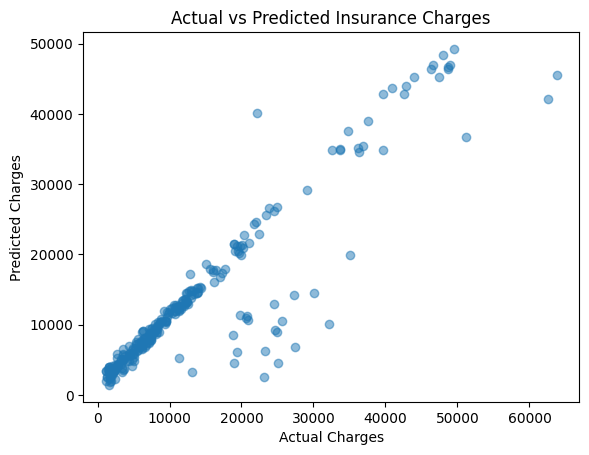

In [120]:
# Compare predictions vs actual values
import matplotlib.pyplot as plt
plt.scatter(y_test_np, y_pred_np, alpha=0.5)
plt.xlabel("Actual Charges")
plt.ylabel("Predicted Charges")
plt.title("Actual vs Predicted Insurance Charges")
plt.show()


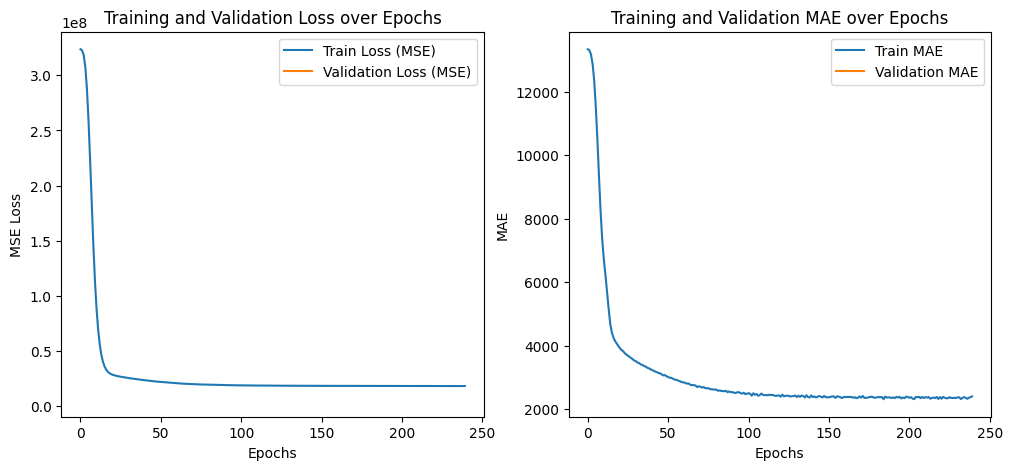

In [121]:
# Plot training & validation loss values
plt.figure(figsize=(12, 5))

# Loss (MSE) Plot
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss (MSE)')
plt.plot(history['val_loss'], label='Validation Loss (MSE)')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()

# Mean Absolute Error (MAE) Plot
plt.subplot(1, 2, 2)
plt.plot(history['train_mae'], label='Train MAE')
plt.plot(history['val_mae'], label='Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.title('Training and Validation MAE over Epochs')
plt.legend()

plt.show()


In [59]:
fig = px.box(data, x='region', y='charges', color='smoker', title='Interactive Boxplot of Charges by Region and Smoking Status')
fig.show()



In [64]:
fig = px.box(
    data,
    x='bmi_group',
    y='charges',
    color='smoker',
    title='Interactive Boxplot of Charges by BMI-Index and Smoking Status',
    category_orders={"bmi_group": ["Under 20", "20-25", "25-30", "30 and above"]}  # Define the order
)
fig.show()

## Summary
**Age and BMI** have a strong positive association with insurance charges.

For people with a **high BMI**, **smoking** has a more serious impact on charges than people with a **low BMI**.


**Smoking** is the most influential factor affecting charges.

**Regions** have only a minor impact.